In [12]:
!pip install qiskit
!pip install qiskit-aer


In [13]:
!pip install qiskit_machine_learning

In [14]:
!pip install qiskit_algorithms

In [15]:
# Quantum Machine Learning Project Pipeline (Python Script)
#
# This script provides a comprehensive, step-by-step pipeline for approaching
# Quantum Machine Learning (QML) projects. It covers data preparation,
# quantum circuit design (feature maps and ansatz), model definition (VQC and QSVC),
# training, evaluation, and visualization. It also includes sections on hyperparameter
# tuning and advanced topics to guide future projects.

# --- Step 1: Setting Up Your Environment and Importing Libraries ---
#
# Before diving into the quantum algorithms, it's crucial to set up your Python
# environment and import all necessary libraries. We will primarily use Qiskit,
# IBM's open-source quantum computing framework.

# Uncomment the following lines to install Qiskit and Qiskit Machine Learning
# if you haven't already.
# !pip install qiskit qiskit-machine_learning qiskit-aer qiskit-algorithms matplotlib numpy scikit-learn seaborn

# Import necessary libraries
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.algorithms.classifiers import VQC, QSVC
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_aer import AerSimulator # Used for simulating quantum circuits
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_machine_learning.kernels import FidelityQuantumKernel # For QSVC
import matplotlib.pyplot as plt
from qiskit.circuit import ParameterVector
import numpy as np
from sklearn.model_selection import train_test_split # Not directly used with ad_hoc_data, but useful for custom datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [16]:
 %matplotlib inline

print("Libraries imported successfully.")

# --- Step 2: Data Preparation ---
#
# Data preparation is a critical step in any machine learning project, quantum or classical.
# This involves generating or loading your dataset, preprocessing it, and splitting it
# into training and testing sets.

# 2.1 Data Generation/Loading
# For demonstration purposes, we'll use Qiskit's `ad_hoc_data` function, which generates
# a simple binary classification dataset. In a real-world scenario, you would load your
# own dataset (e.g., from CSV, NumPy arrays, etc.).

# Define dataset parameters
feature_dim = 2  # Number of features (qubits)
training_size = 40 # Increased training size for better generalization
testing_size = 20  # Increased testing size
gap = 0.5          # Increased gap for clearer separation

# Generate synthetic ad-hoc data for binary classification
training_features, training_labels, testing_features, testing_labels = ad_hoc_data(
    training_size=training_size,
    test_size=testing_size,
    n=feature_dim,
    gap=gap,
    plot_data=False # We will plot it explicitly later
)

print(f"\nTraining features shape: {training_features.shape}")
print(f"Training labels shape: {training_labels.shape}")
print(f"Testing features shape: {testing_features.shape}")
print(f"Testing labels shape: {testing_labels.shape}")


Libraries imported successfully.

Training features shape: (80, 2)
Training labels shape: (80, 2)
Testing features shape: (40, 2)
Testing labels shape: (40, 2)


In [17]:
# 2.2 Data Preprocessing and Normalization
# Quantum circuits often require input data to be normalized within a specific range
# (e.g., [0, 2*pi] or [0, 1]) depending on the chosen feature map. We'll use
# `MinMaxScaler` for this purpose and ensure labels are in the correct format
# (one-hot encoded if necessary, or numerical for VQC).

# Ensure input data is in the correct format (NumPy arrays)
training_features = np.array(training_features)
training_labels = np.array(training_labels)
testing_features = np.array(testing_features)
testing_labels = np.array(testing_labels)

# Convert labels from one-hot encoding to class indices for plotting and QSVC
training_labels_indexed = np.argmax(training_labels, axis=1)
testing_labels_indexed = np.argmax(testing_labels, axis=1)


# Normalize features to the range [0, 2*pi] for common feature maps (e.g., ZZFeatureMap)
# For RealAmplitudes with RX gates, [0, pi] or [0, 2*pi] might be suitable.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
training_features_scaled = scaler.fit_transform(training_features)
testing_features_scaled = scaler.transform(testing_features)

print("\nFeatures scaled successfully.")
print(f"Min value of scaled training features: {np.min(training_features_scaled)}")
print(f"Max value of scaled training features: {np.max(training_features_scaled)}")



Features scaled successfully.
Min value of scaled training features: 0.0
Max value of scaled training features: 6.283185307179585


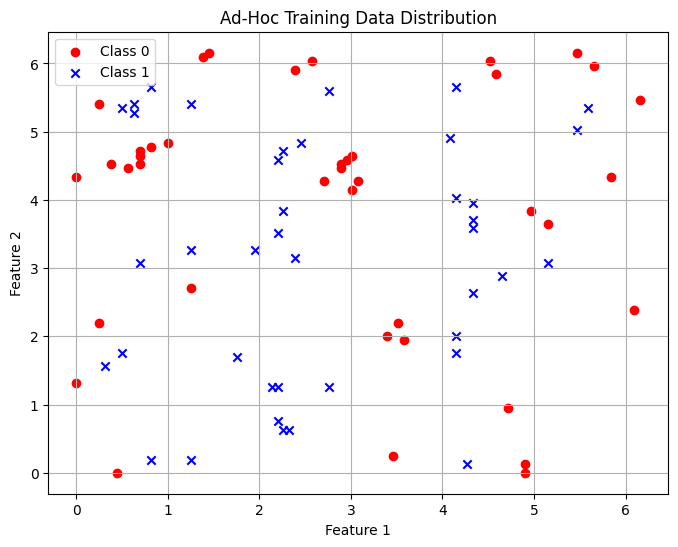

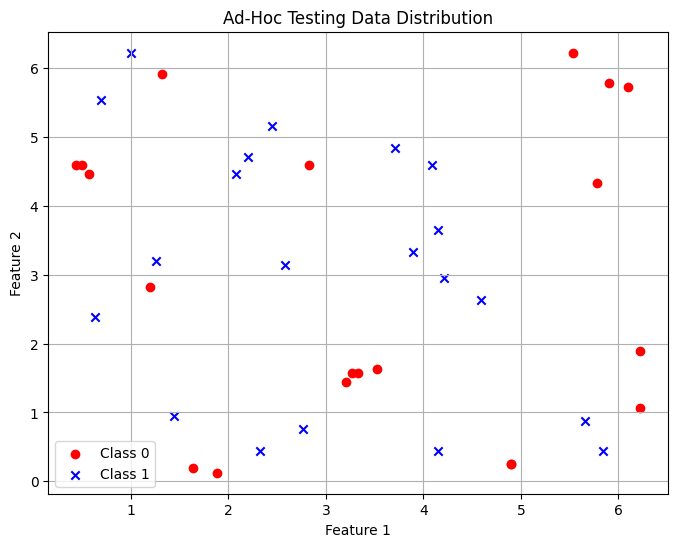


Custom Feature Map:
     ┌───────────┐
q_0: ┤ R(x[0],0) ├
     ├───────────┤
q_1: ┤ R(x[1],0) ├
     └───────────┘

ZZFeatureMap:
     ┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                          
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └─────────────┘└───┘└──────────────────────────────┘└───┘


In [18]:

# 2.3 Visualizing the Data
# It's always a good practice to visualize your data to understand its distribution and separability.

# Visualize the training data
plt.figure(figsize=(8, 6))
plt.scatter(training_features[training_labels_indexed == 0, 0], training_features[training_labels_indexed == 0, 1], label='Class 0', marker='o', c='red')
plt.scatter(training_features[training_labels_indexed == 1, 0], training_features[training_labels_indexed == 1, 1], label='Class 1', marker='x', c='blue')
plt.title('Ad-Hoc Training Data Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the testing data
plt.figure(figsize=(8, 6))
plt.scatter(testing_features[testing_labels_indexed == 0, 0], testing_features[testing_labels_indexed == 0, 1], label='Class 0', marker='o', c='red')
plt.scatter(testing_features[testing_labels_indexed == 1, 0], testing_features[testing_labels_indexed == 1, 1], label='Class 1', marker='x', c='blue')
plt.title('Ad-Hoc Testing Data Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

# --- Step 3: Designing Quantum Circuits ---
#
# The core of a QML model lies in its quantum circuits: the feature map and the
# variational circuit (ansatz).

# 3.1 Feature Map (Encoding Data)
# A feature map encodes classical data into a quantum state. This is crucial as it allows
# the quantum computer to process the data. Different feature maps can lead to
# different performance characteristics.

# Option 1: Custom Feature Map (as in the reference notebook)
def create_custom_feature_map(feature_dim):
    qc = QuantumCircuit(feature_dim)
    feature_params = ParameterVector('x', feature_dim)
    for i in range(feature_dim):
        qc.rx(feature_params[i], i) # Apply RX gate, encoding data into rotation around X-axis
    qc.name = "Custom Feature Map"
    return qc

custom_feature_map = create_custom_feature_map(feature_dim)
print("\nCustom Feature Map:")
print(custom_feature_map.decompose().draw('text'))

# Option 2: Qiskit's built-in ZZFeatureMap
# This feature map is known for its ability to create entanglement, which is crucial for QML.
zz_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
print("\nZZFeatureMap:")
print(zz_feature_map.decompose().draw('text'))

# Choose the feature map to use for the model
feature_map = zz_feature_map # Let's use ZZFeatureMap for this pipeline

In [19]:

# 3.2 Variational Circuit (Ansatz)
# The variational circuit, also known as the ansatz, is a parameterized quantum circuit
# that is optimized during the training process. Its parameters are adjusted to minimize
# a cost function.

# Option 1: Custom Variational Circuit (as in the reference notebook)
def create_custom_var_circuit(feature_dim):
    qc = QuantumCircuit(feature_dim)
    var_params = ParameterVector('θ', feature_dim) # Use theta for variational parameters
    for i in range(feature_dim):
        qc.ry(var_params[i], i) # Apply RY gate, allowing rotation around Y-axis
    qc.name = "Custom Ansatz"
    return qc

custom_var_circuit = create_custom_var_circuit(feature_dim)
print("\nCustom Variational Circuit:")
print(custom_var_circuit.decompose().draw('text'))

# Option 2: Qiskit's built-in RealAmplitudes ansatz
# This is a common ansatz for variational algorithms.
real_amplitudes_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=2)
print("\nRealAmplitudes Ansatz:")
print(real_amplitudes_ansatz.decompose().draw('text'))

# Choose the ansatz to use for the model
ansatz = real_amplitudes_ansatz # Let's use RealAmplitudes for this pipeline


Custom Variational Circuit:
     ┌─────────────┐
q_0: ┤ R(θ[0],π/2) ├
     ├─────────────┤
q_1: ┤ R(θ[1],π/2) ├
     └─────────────┘

RealAmplitudes Ansatz:
     ┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├──■──┤ Ry(θ[4]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘


In [20]:
# --- Step 4: Defining the Quantum Machine Learning Model ---
#
# Qiskit Machine Learning provides various quantum machine learning algorithms.
# We will focus on two popular classifiers: Variational Quantum Classifier (VQC)
# and Quantum Support Vector Classifier (QSVC).

# 4.1 Choosing a Primitive
# Qiskit Primitives are high-level interfaces that allow users to execute quantum
# circuits more efficiently. We'll use `Sampler` for VQC and `Estimator` for QSVC.
# - Sampler: Returns quasi-probability distributions of bitstrings from quantum circuits.
# - Estimator: Estimates expectation values of quantum observables.

# Initialize Sampler and Estimator primitives
sampler = Sampler()
estimator = Estimator()

print("\nSampler and Estimator primitives initialized.")

# 4.2 Choosing an Optimizer
# For VQC, an optimizer is needed to adjust the parameters of the ansatz.
# `COBYLA` is a good choice for gradient-free optimization, suitable for quantum circuits.
# For QSVC, the optimization is handled internally by the classical SVM solver,
# which uses the quantum kernel.

# Define an optimizer for VQC
optimizer = COBYLA(maxiter=100) # You can adjust maxiter based on convergence needs
print(f"\nOptimizer chosen for VQC: {optimizer.__class__.__name__}")

# 4.3 Initializing the Classifier (VQC or QSVC)

# Variational Quantum Classifier (VQC)
# VQC is a quantum-classical hybrid algorithm that uses a parameterized quantum circuit
# (ansatz) to learn a classification boundary. It's trained by minimizing a cost function
# using a classical optimizer.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters) * 2 * np.pi # Random initial parameters
)
print("\nVQC initialized.")

# Quantum Support Vector Classifier (QSVC)
# QSVC is a quantum enhanced version of the classical Support Vector Machine.
# Instead of a classical kernel, it uses a quantum kernel, which is derived from the
# feature map. This allows the SVM to operate in a high-dimensional quantum Hilbert space.

# Initialize a quantum kernel using the chosen feature map
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Initialize QSVC with the quantum kernel
qsvc = QSVC(quantum_kernel=quantum_kernel)
print("QSVC initialized.")


Sampler and Estimator primitives initialized.

Optimizer chosen for VQC: COBYLA

VQC initialized.
QSVC initialized.


/tmp/ipython-input-20-719767269.py:14: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/tmp/ipython-input-20-719767269.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [21]:

# --- Step 5: Training the Model ---
#
# Training involves fitting the chosen QML model to your training data.
# This is where the optimization process takes place.

print("\nTraining VQC...")
# VQC expects one-hot encoded labels
vqc_result = vqc.fit(training_features_scaled, training_labels)
print("VQC training complete.")

print("\nTraining QSVC...")
# QSVC expects indexed labels (1D array)
qsvc_result = qsvc.fit(training_features_scaled, training_labels_indexed)
print("QSVC training complete.")


Training VQC...
VQC training complete.

Training QSVC...
QSVC training complete.


In [22]:

# --- Step 6: Prediction and Evaluation ---
#
# After training, the model's performance needs to be evaluated on unseen data
# (the testing set). We'll predict labels for the test data and calculate metrics
# like accuracy, precision, recall, and F1-score.

# VQC Prediction and Evaluation
vqc_predicted_labels = np.argmax(vqc.predict(testing_features_scaled), axis=1) # Convert to 1D class indices
vqc_accuracy = accuracy_score(testing_labels_indexed, vqc_predicted_labels) # Use indexed labels for comparison
print(f"\n--- VQC Results ---")
print(f"VQC Test Accuracy: {vqc_accuracy:.4f}")
print("VQC Classification Report:")
print(classification_report(testing_labels_indexed, vqc_predicted_labels)) # Use indexed labels for comparison

# QSVC Prediction and Evaluation
qsvc_predicted_labels = qsvc.predict(testing_features_scaled).astype(int) # QSVC predict returns 1D already, just ensure int
qsvc_accuracy = accuracy_score(testing_labels_indexed, qsvc_predicted_labels) # Use indexed labels for comparison
print(f"\n--- QSVC Results ---")
print(f"QSVC Test Accuracy: {qsvc_accuracy:.4f}")
print("QSVC Classification Report:")
print(classification_report(testing_labels_indexed, qsvc_predicted_labels)) # Use indexed labels for comparison



--- VQC Results ---
VQC Test Accuracy: 0.8500
VQC Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.79      0.95      0.86        20

    accuracy                           0.85        40
   macro avg       0.86      0.85      0.85        40
weighted avg       0.86      0.85      0.85        40


--- QSVC Results ---
QSVC Test Accuracy: 0.9500
QSVC Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



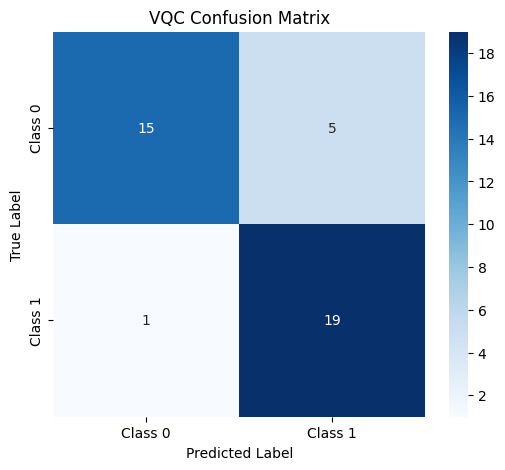

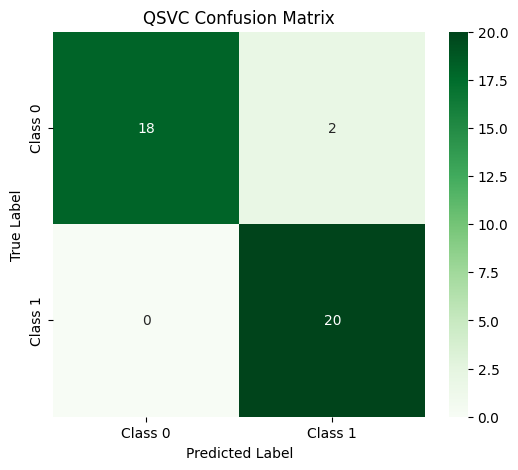

In [23]:

# 6.1 Confusion Matrix
# A confusion matrix provides a detailed breakdown of correct and incorrect
# classifications for each class.

# VQC Confusion Matrix
vqc_cm = confusion_matrix(testing_labels_indexed, vqc_predicted_labels) # Use indexed labels for confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(vqc_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('VQC Confusion Matrix')
plt.show()

# QSVC Confusion Matrix
qsvc_cm = confusion_matrix(testing_labels_indexed, qsvc_predicted_labels) # Use indexed labels for confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(qsvc_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('QSVC Confusion Matrix')
plt.show()

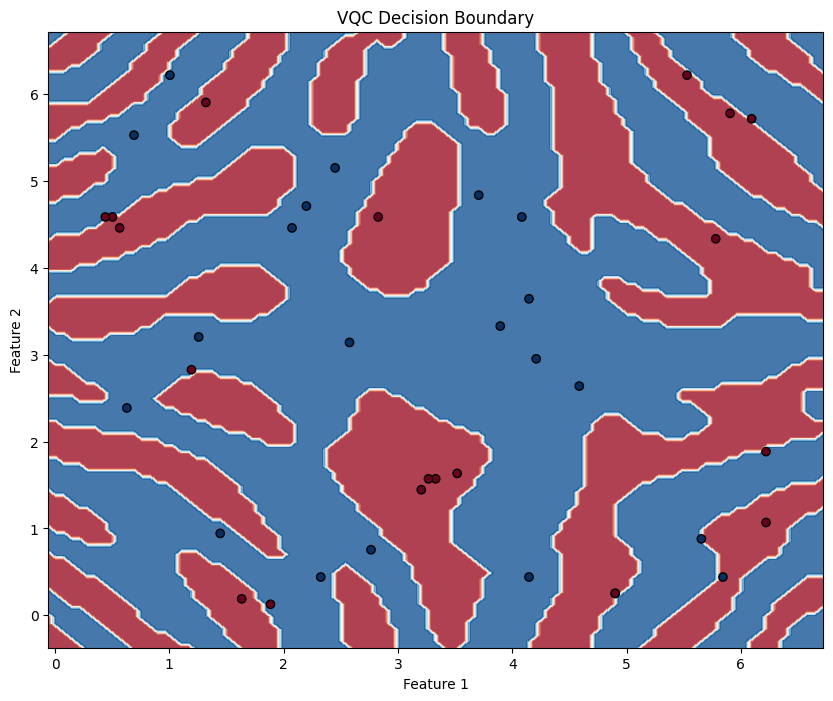

In [ ]:

# --- Step 7: Visualizing Decision Boundaries (for 2D data) ---
#
# For 2-dimensional datasets, visualizing the decision boundary can provide
# intuitive insights into how the model classifies data points.

def plot_decision_boundary(model, features, labels, title):
    """
    Plots the decision boundary for a 2D classifier.

    Args:
        model: The trained QML classifier (VQC or QSVC).
        features: The original (unscaled) features used for plotting.
        labels: The true labels.
        title: The title of the plot.
    """
    x_min, x_max = features[:, 0].min() - 0.5, features[:, 0].max() + 0.5
    y_min, y_max = features[:, 1].min() - 0.5, features[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Predict on the meshgrid points
    # Scale the meshgrid points before prediction, just like the training/testing data
    Z = model.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
    # Convert predictions to class indices for plotting decision boundary
    if Z.ndim > 1 and Z.shape[-1] > 1: # Check if it's multi-dimensional output (e.g., probabilities or one-hot)
         Z = np.argmax(Z, axis=-1) # Use axis=-1 to handle both (N, C) and (N, 1, C) shapes


    Z = Z.reshape(xx.shape)


    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap=plt.cm.RdBu, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Plot decision boundary for VQC
plot_decision_boundary(vqc, testing_features, testing_labels_indexed, 'VQC Decision Boundary') # Use indexed labels for plotting

# Plot decision boundary for QSVC
plot_decision_boundary(qsvc, testing_features, testing_labels_indexed, 'QSVC Decision Boundary') # Use indexed labels for plotting


In [ ]:

# --- Step 8: Hyperparameter Tuning and Model Optimization ---
#
# Just like classical machine learning, QML models benefit from hyperparameter tuning.
# This can involve:
# - Optimizer parameters: `maxiter`, `tol` for `COBYLA`, learning rate for `SPSA`, etc.
# - Ansatz design: Number of layers (`reps`), type of gates, entanglement strategy.
# - Feature map design: Type of encoding, number of repetitions.
# - Data preprocessing: Scaling ranges, feature engineering.
#
# This is an iterative process often involving techniques like grid search,
# random search, or more advanced optimization algorithms.

# Example: Exploring a different optimizer (SPSA) for VQC

# Define a new optimizer (SPSA - Simultaneous Perturbation Stochastic Approximation)
spsa_optimizer = SPSA(maxiter=100, learning_rate=0.05, perturbation=0.02)

# Re-initialize VQC with the new optimizer
vqc_spsa = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=spsa_optimizer,
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters) * 2 * np.pi
)

print("\nTraining VQC with SPSA optimizer...")
vqc_spsa.fit(training_features_scaled, training_labels)
print("VQC (SPSA) training complete.")

vqc_spsa_predicted_labels = np.argmax(vqc_spsa.predict(testing_features_scaled), axis=1) # Convert to 1D class indices
vqc_spsa_accuracy = accuracy_score(testing_labels_indexed, vqc_spsa_predicted_labels) # Use indexed labels for comparison
print(f"\n--- VQC (SPSA) Results ---")
print(f"VQC (SPSA) Test Accuracy: {vqc_spsa_accuracy:.4f}")
print("VQC (SPSA) Classification Report:")
print(classification_report(testing_labels_indexed, vqc_spsa_predicted_labels)) # Use indexed labels for comparison


In [ ]:

# --- Step 9: Advanced Topics and Next Steps ---
#
# This script provides a basic pipeline. For more advanced QML projects, consider exploring:
# - Real Quantum Hardware: Running your circuits on actual quantum computers
#   (via IBM Quantum Experience) instead of simulators. Be aware of noise and limited
#   qubit availability.
# - Error Mitigation: Techniques to reduce the impact of noise on quantum hardware.
# - More Complex Datasets: Applying QML to real-world datasets from various domains
#   (e.g., image classification, natural language processing).
# - Other QML Algorithms: Explore Quantum Neural Networks (QNNs), Quantum Generative
#   Adversarial Networks (QGANs), Quantum Reinforcement Learning, etc.
# - Custom Cost Functions: For VQC, you can define custom cost functions beyond
#   simple classification accuracy.
# - Feature Engineering: How to map higher-dimensional classical data into quantum
#   states effectively.
# - Hybrid Quantum-Classical Models: Integrating quantum components into larger
#   classical machine learning pipelines.
#
# QML is a rapidly evolving field. Stay updated with the latest research and Qiskit
# releases to leverage new features and best practices.